In [7]:
%matplotlib inline
import warnings
warnings. filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn. feature_extraction. text import TfidfTransformer
from sklearn. feature_extraction. text import TfidfVectorizer
from sklearn. feature_extraction. text import CountVectorizer
from sklearn. metrics import confusion_matrix
from sklearn import metrics
from sklearn. metrics import roc_curve, auc
from nltk. stem. porter import PorterStemmer
import re
import string
from nltk. corpus import stopwords
from nltk. stem import PorterStemmer
from nltk. stem. wordnet import WordNetLemmatizer
from gensim. models import Word2Vec
from gensim. models import KeyedVectors
import pickle
import scipy as sp
from tqdm import tqdm
import os
from sklearn. cross_validation import train_test_split
from sklearn. neighbors import KNeighborsClassifier
from sklearn. metrics import accuracy_score
from sklearn. cross_validation import cross_val_score
from collections import Counter
from sklearn. metrics import accuracy_score
from sklearn import cross_validation
from sklearn. metrics import confusion_matrix
from sklearn. preprocessing import normalize
from sklearn import datasets, neighbors
from sklearn. metrics import roc_auc_score
from sklearn. preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [2]:
from scipy.sparse import load_npz

path = "C:/Python/Assignments/Preprocessing/"

train_bow = load_npz(path + "train_bow.npz")
test_bow = load_npz(path + "test_bow.npz")
cv_bow = load_npz(path + "cv_bow.npz")

train_tfidf = load_npz(path + "train_tfidf.npz")
test_tfidf = load_npz(path + "test_tfidf.npz")
cv_tfidf = load_npz(path + "cv_tfidf.npz")

with open(path +"X_test.txt", "rb") as file:
    X_test = pickle.load(file)
with open(path +"X_train.txt", "rb") as file:
    X_train = pickle.load(file)
with open(path +"X_cv.txt", "rb") as file:
    X_cv = pickle.load(file)
    
with open(path +"Y_test.txt", "rb") as file:
    Y_test = pickle.load(file)
with open(path +"Y_train.txt", "rb") as file:
    Y_train = pickle.load(file)
with open(path +"Y_cv.txt", "rb") as file:
    Y_cv = pickle.load(file)

with open(path + "X_cv_sum.txt", "rb") as file:
    X_cv_sum = pickle.load(file)
with open(path + "X_train_sum.txt", "rb") as file:
    X_train_sum = pickle.load(file)
with open(path + "X_test_sum.txt", "rb") as file:
    X_test_sum = pickle.load(file)

with open(path + "train_avgw2v.txt", "rb") as file:
    train_avgw2v = pickle.load(file)
with open(path + "cv_avgw2v.txt", "rb") as file:
    cv_avgw2v = pickle.load(file)
with open(path + "test_avgw2v.txt", "rb") as file:
    test_avgw2v = pickle.load(file)

with open(path + "train_tfw2v.txt", "rb") as file:
    train_tfw2v = pickle.load(file)
with open(path + "cv_tfw2v.txt", "rb") as file:
    cv_tfw2v = pickle.load(file)
with open(path + "test_tfw2v.txt", "rb") as file:
    test_tfw2v = pickle.load(file)
    

# SVM function

In [10]:
def svm(train1,test1,cv1):

    sc = StandardScaler(with_mean=False)
    train = sc.fit_transform(train1)    
    cv = sc.fit_transform(cv1)
    test = sc.transform(test1)
    
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]
    Penal = ['l1','l2']
    parameter = {'alpha':Alpha, 'penalty':Penal}
    
    clf = GridSearchCV(SGDClassifier(),parameter,verbose=1,scoring='roc_auc')
    clf.fit(train,Y_train)
    alpha_opt, penalty_opt = clf.best_params_.get('alpha'), clf.best_params_.get('penalty')
    
    
    print("The optimal value of Alpha = ", alpha_opt , " And Optimal Penalty is : ", penalty_opt)
    
    SGD = SGDClassifier(penalty=penalty_opt,alpha=alpha_opt)
    SGD.fit(train,Y_train)
    
    # Since decision function gives probability values
    fpr, tpr, threshold = roc_curve(Y_train, SGD.decision_function(train) )
    fpr1, tpr1, threshold1 = roc_curve(Y_test, SGD.decision_function(test) )
    pred = SGD.predict(test)
    print("The AUC value for test data is ",roc_auc_score( Y_test, pred))

    plt.plot(fpr,tpr,'r', label = 'Train Data')
    plt.plot(fpr1,tpr1,'b', label = 'Test Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("ROC Curve for Train and Test Data\n")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()


## Calculate Helpfulness percentage to add as a feature

In [11]:
# Get the helpfulness data
with open(path + "final_sorted.txt", "rb") as file:
    sorted_data = pickle.load(file)
my_final = sorted_data[:100000]
my_final['Helpful_percent'] = (my_final['HelpfulnessNumerator'] / my_final['HelpfulnessDenominator'])*100
my_final['Helpful_percent'].fillna(0, inplace=True)
from sklearn.model_selection import train_test_split
x = my_final['Helpful_percent'].values
y = my_final['Score']

# split the data set into train and test
X_1, X_test_perc, y_1, Y_test1 = cross_validation.train_test_split(x, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train_perc, X_cv_perc, Y_train1, Y_cv1 = cross_validation.train_test_split(X_1, y_1, test_size=0.3,random_state=0)
# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix/41948136
from scipy.sparse import hstack
def addmat(col,csr_mat):
    '''
    Add a new column to sarse matrix with the number of words in each entry of col
    '''
    leng = []
    for i in col:
        leng.append(len(i.split(" ")))
    train_bow = hstack((csr_mat,pd.Series(leng)[:,None]))
    return train_bow.tocsr()


# BOW

With review text and summary both


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    7.7s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.6748134993787414


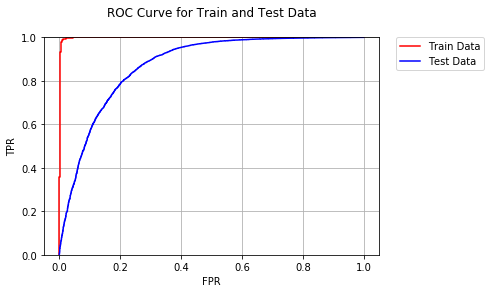

With review text length


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    8.1s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.6724077508003059


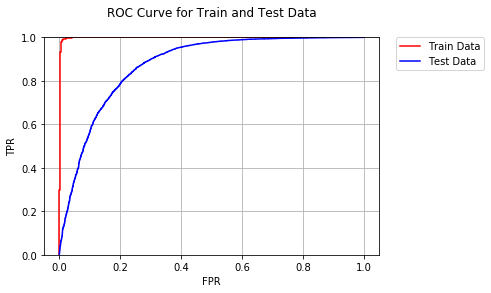



With review summary length


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    8.5s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.6549395953232449


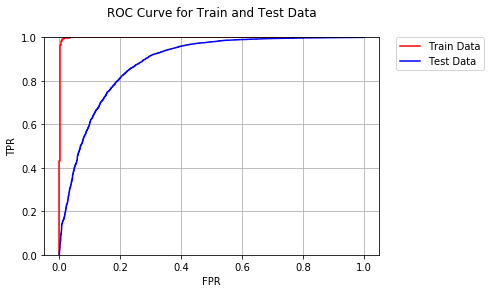



With helpfullness percentage


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    7.9s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.653552830035711


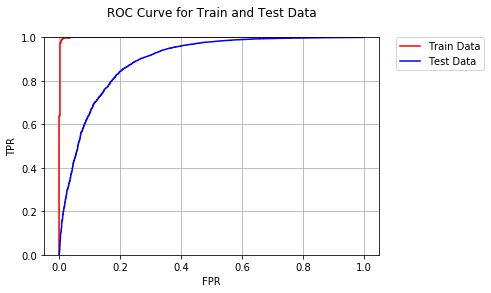

In [12]:
#Adding review text and review summary to create a new data
train = X_train + X_train_sum
cv = X_cv + X_cv_sum
test = X_test + X_test_sum

#BoW

count_vect = CountVectorizer() #in scikit-learn
train_vect = count_vect.fit_transform(train)
cv_vect = count_vect.transform(cv)
ts_vect = count_vect.transform(test)
print("With review text and summary both\n\n")

svm(train_vect,ts_vect,cv_vect)
print("With review text length\n\n")
# Adding the number of words each review text as a new feature
tr1 = addmat(X_train,train_vect)
cv1 = addmat(X_cv,cv_vect)
ts1 = addmat(X_test,ts_vect)
svm(tr1,ts1,cv1)
print("\n\nWith review summary length\n\n")
# Adding the number of words each review summary as a new feature
tr1 = addmat(X_train_sum,tr1)
cv1 = addmat(X_cv_sum,cv1)
ts1 = addmat(X_test_sum,ts1)

svm(tr1,ts1,cv1)
print("\n\nWith helpfullness percentage\n\n")
# Adding Helpfulness Percentage as a new feature
tr1 = hstack((tr1,pd.Series(X_train_perc)[:,None]))
cv1 = hstack((cv1,pd.Series(X_cv_perc)[:,None]))
ts1 = hstack((ts1,pd.Series(X_test_perc)[:,None]))
svm(tr1,ts1,cv1)

# TfIdf

With review text and summary both


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    8.0s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.7158699783537281


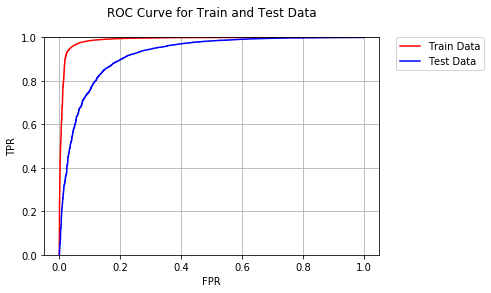

With review text length


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    8.3s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.7173551970090484


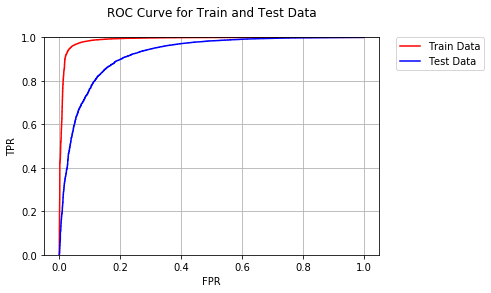



With review summary length


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    8.3s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.7145521122922696


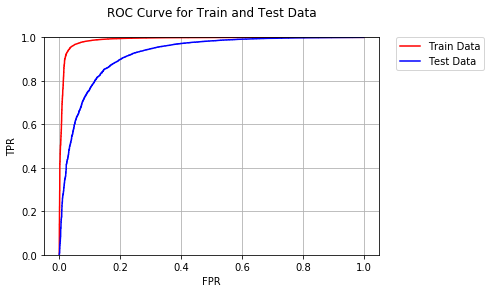



With helpfullness percentage


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    8.0s finished


The optimal value of Alpha =  1  And Optimal Penalty is :  l2
The AUC value for test data is  0.7154916283555024


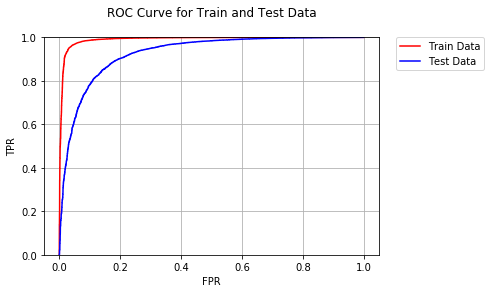

In [13]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_vect = tf_idf_vect.fit_transform(train)
cv_vect = tf_idf_vect.transform(cv)
ts_vect = tf_idf_vect.transform(test)
print("With review text and summary both\n\n")

svm(train_vect,ts_vect,cv_vect)
print("With review text length\n\n")
# Adding the number of words each review text as a new feature
tr1 = addmat(X_train,train_vect)
cv1 = addmat(X_cv,cv_vect)
ts1 = addmat(X_test,ts_vect)
svm(tr1,ts1,cv1)
print("\n\nWith review summary length\n\n")
# Adding the number of words each review summary as a new feature
tr1 = addmat(X_train_sum,tr1)
cv1 = addmat(X_cv_sum,cv1)
ts1 = addmat(X_test_sum,ts1)

svm(tr1,ts1,cv1)
print("\n\nWith helpfullness percentage\n\n")
# Adding Helpfulness Percentage as a new feature
tr1 = hstack((tr1,pd.Series(X_train_perc)[:,None]))
cv1 = hstack((cv1,pd.Series(X_cv_perc)[:,None]))
ts1 = hstack((ts1,pd.Series(X_test_perc)[:,None]))
svm(tr1,ts1,cv1)

# Conclusion

In [14]:
# Please compare all your models using Prettytable library
from prettytable import from_csv
with open("added.csv", "r") as fp: 
    x = from_csv(fp)
    
print(x)

+------------+--------------------------------+-----------------+---------+-----------+
| Vectorizer |       New Feature Added        | Hyper Parameter | Penalty | AUC Value |
+------------+--------------------------------+-----------------+---------+-----------+
|    BOW     |        Only Review Text        |        1        |    l2   |    0.74   |
|    BOW     | Review Summary along with Text |        1        |    l2   |    0.67   |
|    BOW     |       Review text length       |        1        |    l2   |    0.67   |
|    BOW     |     Review summary length      |        1        |    l2   |    0.65   |
|    BOW     |     Helpfulness Percentage     |        1        |    l2   |    0.65   |
|   TFIDF    |        Only Review Text        |        1        |    l2   |    0.71   |
|   TFIDF    | Review Summary along with Text |        1        |    l2   |    0.71   |
|   TFIDF    |       Review text length       |        1        |    l2   |    0.71   |
|   TFIDF    |     Review summar

1. There is no significant improvement on the model after adding the new features mentioned above.
2. There may be other features which will improve the model more than this.